## Review Dataset and Build Image loading function

In [1]:
import zipfile

def unzip_data(filename: str,data_dir="data") -> None:
    """
    Unzips filename into the current working directory.
    Args:
        filename (str): a filepath to a target zip folder to be unzipped.
    """
    zip_ref = zipfile.ZipFile(filename, "r")
    zip_ref.extractall(data_dir)
    zip_ref.close()

In [5]:
unzip_data("/content/zipped_data.zip")
unzip_data("/content/train.zip")
unzip_data("/content/test.zip")
unzip_data("/content/val.zip")

In [ ]:
from pathlib import Path
Path.cwd()

PosixPath('/content')

### Import TF and Deps

In [6]:
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt
import os

### Load Images into TF data pipeline

In [ ]:
images = tf.data.Dataset.list_files('/content/data/data/images/*.jpg', shuffle=False)

In [ ]:
def load_img(x):
  """
  Reads in the file and spits out image as an array
  """
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_image(byte_img)
  return img

In [ ]:
images = images.map(load_img)

In [ ]:
images.as_numpy_iterator().next()

array([[[52, 50, 53],
        [49, 47, 50],
        [47, 45, 48],
        ...,
        [21, 22, 26],
        [19, 23, 26],
        [18, 22, 25]],

       [[51, 49, 52],
        [49, 47, 50],
        [47, 45, 48],
        ...,
        [24, 25, 29],
        [24, 25, 29],
        [22, 26, 29]],

       [[51, 49, 52],
        [49, 47, 50],
        [47, 45, 48],
        ...,
        [24, 25, 29],
        [23, 24, 28],
        [22, 23, 27]],

       ...,

       [[31, 26, 32],
        [38, 33, 39],
        [42, 37, 43],
        ...,
        [21, 17, 16],
        [22, 18, 17],
        [22, 18, 17]],

       [[29, 19, 27],
        [37, 27, 35],
        [42, 32, 40],
        ...,
        [18, 18, 18],
        [19, 19, 19],
        [19, 19, 19]],

       [[26, 15, 23],
        [35, 24, 32],
        [41, 30, 38],
        ...,
        [17, 19, 18],
        [18, 20, 19],
        [18, 20, 19]]], dtype=uint8)

### View images using `matpotlib`

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
to_plot_images = image_generator.next()

In [ ]:
# Uncomment below code to see the data

# fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# for idx, image in enumerate(to_plot_images):
#   ax[idx].imshow(image)

# plt.show()

## Partition data and move files

In [ ]:
!mkdir /content/data/train
!mkdir /content/data/train/images
!mkdir /content/data/train/labels

!mkdir /content/data/val
!mkdir /content/data/val/images
!mkdir /content/data/val/labels

!mkdir /content/data/test
!mkdir /content/data/test/images
!mkdir /content/data/test/labels

In [ ]:
import random
import shutil
import os
from pathlib import Path
random.seed(42)

N_VAL = 13
N_TEST = 14

image_fileset = os.listdir('/content/data/data/images')
labels_fileset = os.listdir('/content/data/data/labels')

base_path = '/content/data/data/images'

# val_imgs, val_labels = zip(*random.sample(list(zip(image_fileset, labels_fileset)), N_VAL))
# set1 = set(image_fileset)
# set2 = set(val_imgs)
# image_fileset = list(set1 - set2)
# set1 = set(labels_fileset)
# set2 = set(val_labels)
# labels_fileset = list(set1 - set2)

# test_imgs, test_labels = zip(*random.sample(list(zip(image_fileset, labels_fileset)), N_TEST))
# set1 = set(image_fileset)
# set2 = set(test_imgs)
# train_imgs = list(set1 - set2)
# set1 = set(labels_fileset)
# set2 = set(test_labels)
# train_labels = list(set1 - set2)

In [ ]:
len(image_fileset), len(labels_fileset)

(90, 82)

In [ ]:
from sklearn.model_selection import train_test_split

train_val_imgs, train_val_labels, test_imgs, test_labels = train_test_split(image_fileset, labels_fileset, test_size=0.15)
train_imgs, train_labels, val_imgs, val_labels = train_test_split(train_val_imgs, train_val_labels, test_size=0.15)

ValueError: ignored

In [ ]:
# for file_name in train_imgs:
#   prev_file_path = Path.cwd() / "data" / "data" / "images" / file_name
#   new_file_path = Path.cwd() / "data" / "train" / "images" / file_name
#   shutil.move(prev_file_path, new_file_path)

# for file_name in train_labels:
#   prev_file_path = Path.cwd() / "data" / "data" / "labels" / file_name
#   new_file_path = Path.cwd() / "data" / "train" / "labels" / file_name
#   shutil.move(prev_file_path, new_file_path)

# for file_name in val_imgs:
#   prev_file_path = Path.cwd() / "data" / "data" / "images" / file_name
#   new_file_path = Path.cwd() / "data" / "val" / "images" / file_name
#   shutil.move(prev_file_path, new_file_path)

# for file_name in val_labels:
#   prev_file_path = Path.cwd() / "data" / "data" / "labels" / file_name
#   new_file_path = Path.cwd() / "data" / "val" / "labels" / file_name
#   shutil.move(prev_file_path, new_file_path)

# for file_name in test_imgs:
#   prev_file_path = Path.cwd() / "data" / "data" / "images" / file_name
#   new_file_path = Path.cwd() / "data" / "test" / "images" / file_name
#   shutil.move(prev_file_path, new_file_path)

# for file_name in test_labels:
#   prev_file_path = Path.cwd() / "data" / "data" / "labels" / file_name
#   new_file_path = Path.cwd() / "data" / "test" / "labels" / file_name
#   shutil.move(prev_file_path, new_file_path)

### Moving matching labels

In [7]:
for folder in ['train', 'test', 'val']:
  for file in os.listdir(os.path.join('data', folder, 'images')):
    filename = file.split('.')[0] + '.json'
    existing_filepath = os.path.join('data', 'data', 'labels', filename)
    if os.path.exists(existing_filepath):
      new_filepath = os.path.join('data', folder, 'labels', filename)
      os.replace(existing_filepath, new_filepath)

## Apply data augmentation on images and labels using `albumentations`

In [8]:
import albumentations as alb

In [9]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    # alb.RandomBrightnessConstrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(0.5),
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

### Testing the augmentation pipeline

In [21]:
import cv2
img = cv2.imread('/content/data/test/images/32302fba-8133-11ed-9766-6018953ccf15.jpg')

In [22]:
img.shape

(480, 640, 3)

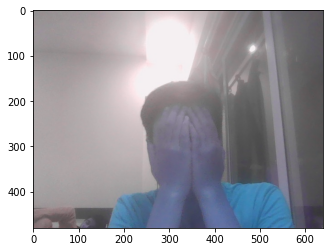

In [26]:
plt.imshow(img)

In [23]:
import json
with open('/content/data/test/labels/32302fba-8133-11ed-9766-6018953ccf15.json', 'r') as f:
  label = json.load(f)

# Remove `32302fba-8133-11ed-9766-6018953ccf15.json` from test folder!

In [25]:
label

{'version': '5.1.1',
 'flags': {},
 'shapes': [],
 'imagePath': '..\\images\\32302fba-8133-11ed-9766-6018953ccf15.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDRIox0PelIzQRTAbn86UcUBcmnYqgEFLjik

In [24]:
label['shapes'][0]

IndexError: ignored

### Extract coordinated

In [14]:
coords = [0, 0, 0, 0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]
coords

[343.97959183673476, 142.55102040816325, 538.8775510204082, 384.38775510204084]

In [15]:
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.5374681122448981,
 0.2969812925170068,
 0.8419961734693878,
 0.8008078231292518]

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [17]:
augmented['image'].shape

(450, 450, 3)

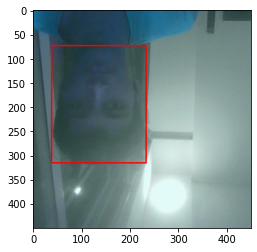

In [18]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)
plt.imshow(augmented['image'])

### Pipeline for each image

In [28]:
!rm -rf aug_data

In [29]:
!mkdir /content/aug_data

!mkdir /content/aug_data/train
!mkdir /content/aug_data/train/images
!mkdir /content/aug_data/train/labels

!mkdir /content/aug_data/val
!mkdir /content/aug_data/val/images
!mkdir /content/aug_data/val/labels

!mkdir /content/aug_data/test
!mkdir /content/aug_data/test/images
!mkdir /content/aug_data/test/labels

In [30]:
for partition in ["train", "test", "val"]:
  for image in os.listdir(os.path.join('data', partition, 'images')):
    img = cv2.imread(os.path.join('data', partition, 'images', image))

    coords = [0, 0, 0.00001, 0.00001]
    label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        label = json.load(f)

      print(f"{partition}\t|{image.split('.')[0]}.json")
      coords[0] = label['shapes'][0]['points'][0][0]
      coords[1] = label['shapes'][0]['points'][0][1]
      coords[2] = label['shapes'][0]['points'][1][0]
      coords[3] = label['shapes'][0]['points'][1][1]
      coords = list(np.divide(coords, [640, 480, 640, 480]))

    try:
      for x in range(60):
        augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
        cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

        annotation = {}
        annotation['image'] = image

        if os.path.exists(label_path):
          if len(augmented['bboxes']) == 0:
            annotation['bbox'] = [0, 0, 0, 0]
            annotation['class'] = 0
          else:
            annotation['bbox'] = augmented['bboxes'][0]
            annotation['class'] = 1
        else:
          annotation['bbox'] = [0, 0, 0, 0]
          annotation['class'] = 0

        with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
          json.dump(annotation, f)
    
    except Exception as e:
      print(e)

train	|9a4bdbea-8130-11ed-bfea-6018953ccf15.json
train	|2e7ff93b-8133-11ed-8640-6018953ccf15.json
train	|6cc6748c-8133-11ed-a502-6018953ccf15.json
train	|a1a987ff-8130-11ed-ad6c-6018953ccf15.json
train	|9429b9f2-8130-11ed-8365-6018953ccf15.json
train	|7d5d597f-8133-11ed-b583-6018953ccf15.json
train	|a381814c-8130-11ed-abf9-6018953ccf15.json
train	|3717dc24-8133-11ed-aab9-6018953ccf15.json
train	|769a1088-8133-11ed-8d62-6018953ccf15.json
train	|9602bf47-8130-11ed-b483-6018953ccf15.json
train	|37b4b1ba-8133-11ed-acfc-6018953ccf15.json
train	|7388d7e4-8133-11ed-a28a-6018953ccf15.json
train	|6f3b734b-8133-11ed-af6e-6018953ccf15.json
train	|97dc3b1b-8130-11ed-8ed7-6018953ccf15.json
train	|a10adc0c-8130-11ed-9dcc-6018953ccf15.json
train	|9c20e7a8-8130-11ed-9231-6018953ccf15.json
train	|a4b8678a-8130-11ed-a7a7-6018953ccf15.json
train	|38efa956-8133-11ed-bf76-6018953ccf15.json
train	|3c9f3a69-8133-11ed-bff2-6018953ccf15.json
train	|6d635c0e-8133-11ed-91ad-6018953ccf15.json
train	|724e3514-8133

## Creating a TF dataset of final augmented images

In [31]:
def load_image(x):
  byte_img = tf.io.read_file(x)
  img = tf.io.decode_jpeg(byte_img)
  return img

In [33]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

## Prepare labels

In [34]:
def load_labels(label_path):
  with open(label_path.numpy(), 'r', encoding="utf-8") as f:
    label = json.load(f)
  
  return [label['class']], label['bbox']

In [35]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## Combine image and label dataset

In [47]:
len(test_images), len(test_labels)

(840, 840)

In [48]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(tf.data.AUTOTUNE)

test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(tf.data.AUTOTUNE)

val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(tf.data.AUTOTUNE)

In [51]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8), array([[0.32    , 0.0913  , 0.728   , 0.631   ],
        [0.581   , 0.      , 1.      , 0.5713  ],
        [0.9893  , 0.013016, 1.      , 0.6523  ],
        [0.57    , 0.2291  , 0.9775  , 0.771   ],
        [0.4553  , 0.2883  , 0.882   , 0.76    ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.3552  , 0.2705  , 0.7817  , 0.742   ],
        [0.2461  , 0.2942  , 0.636   , 0.798   ]], dtype=float16))

## Creating the network

In [52]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

In [53]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

### Custom NN model

In [55]:
def build_model():
  input_layer = layers.Input(shape=(120, 120, 3))
  vgg = VGG16(include_top=False)(input_layer)

  # Determines presence of object
  f1 = layers.GlobalAveragePooling2D()(vgg)
  class1 = layers.Dense(2048, activation='relu')(f1)
  class2 = layers.Dense(1, activation='sigmoid')(class1)

  # Determines location of object
  f2 = layers.GlobalAveragePooling2D()(vgg)
  regress1 = layers.Dense(2048, activation='relu')(f1)
  regress2 = layers.Dense(4, activation='sigmoid')(regress1)

  facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
  return facetracker

In [56]:
facetracker = build_model()
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 512)         0           ['vgg16[0][0]']                  
 alAveragePooling2D)                                                                          

### Testing untrained model

In [57]:
X, y = train.as_numpy_iterator().next()
X.shape

(8, 120, 120, 3)

In [58]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [59]:
classes, coords

(array([[0.51514375],
        [0.5437507 ],
        [0.53740853],
        [0.535606  ],
        [0.545612  ],
        [0.5329793 ],
        [0.5417025 ],
        [0.5460505 ]], dtype=float32),
 array([[0.3377325 , 0.35015154, 0.48456818, 0.25894326],
        [0.35514435, 0.34251484, 0.5067265 , 0.3071561 ],
        [0.3861572 , 0.32702675, 0.47810602, 0.24618027],
        [0.3496043 , 0.348474  , 0.5042334 , 0.3146512 ],
        [0.3799797 , 0.33296287, 0.4834198 , 0.26072666],
        [0.36663064, 0.3308119 , 0.505363  , 0.26254678],
        [0.36189637, 0.34149286, 0.46762276, 0.2654828 ],
        [0.35909665, 0.34257448, 0.47907504, 0.3099606 ]], dtype=float32))

## Defining Loss and optimizer function

In [60]:
batches_per_epoch = 690
lr_decay = (1./0.75 -1)/batches_per_epoch

In [61]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

In [62]:
def localization_loss(y_true, yhat):
  delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - yhat[:, :2]))

  h_true = y_true[:, 3] - y_true[:, 1]
  w_true = y_true[:, 2] - y_true[:, 0]

  h_pred = yhat[:, 3] - yhat[:, 1]
  w_pred = yhat[:, 2] - yhat[:, 0]

  delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

  return delta_coord + delta_size

In [63]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [64]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.058026>

## Train the NN

In [65]:
class FaceTracker(Model):
  def __init__(self, eyetracker, **kwargs):
    super().__init__(**kwargs)
    self.model = eyetracker

  def compile(self, opt, classloss, localizationloss, **kwargs):
    super().compile(**kwargs)
    self.closs = classloss
    self.lloss = localizationloss
    self.opt = opt

  def train_step(self, batch, **kwargs):

    X, y = batch

    with tf.GradientTape() as tape:
      classes, coords = self.model(X, training=True)

      batch_classloss = self.closs(y[0], classes)
      batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

      total_loss = batch_localizationloss + 0.5 * batch_classloss

      grad = tape.gradient(total_loss, self.model.trainable_variables)

    opt.apply_gradients(zip(grad, self.model.trainable_variables))

    return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

  def test_step(self, batch, **kwargs):
    X, y = batch

    classes, coords = self.model(X, training=False)
    batch_classloss = self.closs(y[0], classes)
    batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
    total_loss = batch_localizationloss + 0.5 * batch_classloss

    return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

  def call(self, X, **kwargs):
    return self.model(X, **kwargs)

In [66]:
model = FaceTracker(facetracker)

In [68]:
model.compile(opt, classloss, regressloss)

### Train

In [ ]:
hist = model.fit(train, epochs=40, validation_data = val)

### Plotting loss curves

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

### Predicting on test set

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### Saving the model

In [ ]:
facetracker.save('facetracker.h5')